In [130]:
import pandas as pd
import seaborn as sns
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import networkx as nx
from networkx.algorithms import community
import community as community_louvain
import collections

In [131]:
%load_ext rpy2.ipython
%load_ext autoreload
%autoreload 2

%matplotlib inline  
from matplotlib import rcParams
rcParams['figure.figsize'] = (16, 100)

import warnings
from rpy2.rinterface import RRuntimeWarning
warnings.filterwarnings("ignore") # Ignore all warnings
# warnings.filterwarnings("ignore", category=RRuntimeWarning) # Show some warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, HTML

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [132]:
%%R

require('tidyverse')
library('flextable')
library('GGally')
library('ggraph')
library('gutenbergr')
library('igraph')
library('Matrix')
library('network')
library('quanteda')
library('sna')
library('tidygraph')
library('tidyverse')
library('tm')
library('tibble')
# activate klippy for copy-to-clipboard button
klippy::klippy()

<script>
  addClassKlippyTo("pre.r, pre.markdown");
  addKlippy('left', 'top', 'auto', '1', 'Copy code', 'Copied!');
</script>


In [133]:
data = pd.read_csv('all_data.csv')
data.head()

,from_country,to_country,neighboring,from_country_region,to_country_region,same_region,mean,count
0,Albania,Andorra,0,Central and Eastern Europe,Western Europe,0,1.500000,4
1,Albania,Armenia,0,Central and Eastern Europe,Central and Eastern Europe,1,1.057692,13
2,Albania,Australia,0,Central and Eastern Europe,Non-European,0,3.400000,5
3,Albania,Austria,0,Central and Eastern Europe,Western Europe,0,1.068182,11
4,Albania,Azerbaijan,0,Central and Eastern Europe,Central and Eastern Europe,1,3.229167,12


In [134]:
# Only keep the columns from_country, to_country, and mean
to_from = data[['from_country', 'to_country', 'mean']]

In [135]:
to_from = pd.pivot(to_from, index='from_country', columns='to_country', values='mean')

# Fill NaN with 0
to_from = to_from.fillna(0)

In [136]:
#Find louvian groups
np_matrix = to_from.values
names = to_from.columns
print(names)
G = nx.from_numpy_array(np_matrix)
G = nx.relabel_nodes(G, dict(enumerate(names)))
partition = community_louvain.best_partition(G)

Index(['Albania', 'Andorra', 'Armenia', 'Australia', 'Austria', 'Azerbaijan',
       'Belarus', 'Belgium', 'Bulgaria', 'Croatia', 'Cyprus', 'Czech Republic',
       'Denmark', 'Estonia', 'Finland', 'France', 'Georgia', 'Germany',
       'Greece', 'Hungary', 'Iceland', 'Ireland', 'Israel', 'Italy', 'Latvia',
       'Lithuania', 'Malta', 'Moldova', 'Monaco', 'Montenegro', 'Netherlands',
       'North Macedonia', 'Norway', 'Poland', 'Portugal', 'Romania', 'Russia',
       'San Marino', 'Serbia', 'Slovakia', 'Slovenia', 'Spain', 'Sweden',
       'Switzerland', 'Türkiye', 'Ukraine', 'United Kingdom'],
      dtype='object', name='to_country')


In [137]:
#Asign groups on pandaframe
partition = collections.OrderedDict(sorted(partition.items())) 
to_from['group'] = partition.values()
to_from = to_from.sort_values(by ='group')

In [138]:
#Calculate Asymmetry of each nation
df = pd.DataFrame(columns=list(['Name', 'Asymmetry']))
for i in range(0, np_matrix.shape[0]):
    total = 0
    for k in range(0, np_matrix.shape[0]):
        total += np.abs(np_matrix[i,k] - np_matrix[k,i])
    df = df.append({'Name' : to_from.axes[0][i], 'Asymmetry' : total/np_matrix.shape[0]}, ignore_index=True)
df = df.sort_values(by=['Asymmetry'])

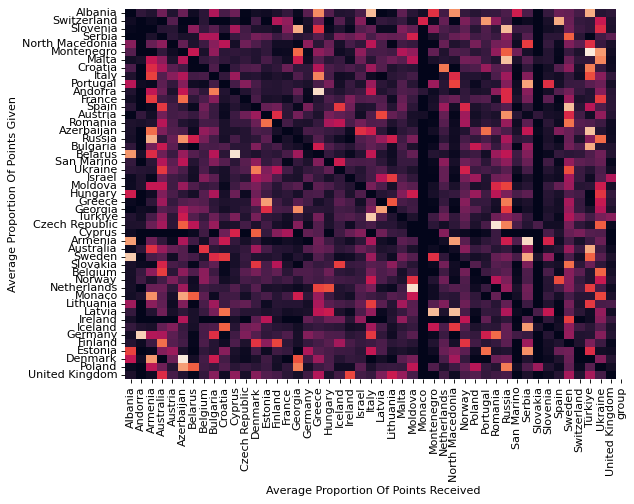

In [139]:
#Create heatmap
figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
x_axis_labels = to_from.axes[1] # labels for x-axis
y_axis_labels = to_from.axes[0] # labels for y-axis
sns.heatmap(np_matrix, xticklabels=x_axis_labels, yticklabels=y_axis_labels,cbar=False)
plt.xlabel("Average Proportion Of Points Received")
plt.ylabel("Average Proportion Of Points Given")
plt.show()